<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_exoplanet_hunter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)

# Exoplanet Hunter: Finding Planets Using Light Intensity

### Tutorial written by Ruhai Lin, Aled dela Cruz, and Karina Aguilar

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/quickstart.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


For a comprehensive overview on how SNNs work, and what is going on under the hood, [then you might be interested in the snnTorch tutorial series available here.](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)
The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:


> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

In this tutorial, you will learn:


*   How to train spiking neural networks for time series data,
*   Using SMOTE to deal with unbalanced datasets,
*   Metrics beyond accuracy to evaluate model performance,
*   Some astronomy knowledge


First install the snntorch library before you run any of the code below.

In [ ]:
!pip install snntorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.7 MB/s eta 0:00:00


And then import the libraries as shown in the code below.

In [ ]:
# imports
import snntorch as snn
from snntorch import surrogate

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

# plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# metric (AUC, ROC, sensitivity & specificity)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# 0. Exoplanet Detection (Optional)
Before diving into the code, let's gain an understanding of what Exoplanet Detection is.

## 0.1 Transit Method

The transit method is a widely used and successful technique for detecting exoplanets. When an exoplanet transits its host star, it causes a temporary reduction in the star's light flux (brightness). Compared to other techniques, the transmit method has has discovered the largest number of planets.

Astronomers use telescopes equipped with photometers or spectrophotometers to continuously monitor the brightness of a star over time. Repeated observations of multiple transits allow astronomers to gather more detailed information about the exoplanet, such as its atmosphere and the presence of moons.

Space telescopes like NASA's Kepler and TESS (Transiting Exoplanet Survey Satellite) have been instrumental in discovering thousands of exoplanets using the transit method. Without the Earth's atmosphere in the way,
there is less interference and more precise measurements are possible. The transit method continues to be a key tool in advancing our understanding of exoplanetary systems. For more information about transit method, you can visit [NASA Exoplanet Exploration Page](https://exoplanets.nasa.gov/alien-worlds/ways-to-find-a-planet/#/2).

## 0.2 Challenges
The drawback of this method is that the angle between the planet's
orbital plane and the direction of the observer's line of sight must be
sufficiently small. Therefore, the chance of this phenomenon occurring is not
high. Thus more time and resources must be spent to detect and confirm the existence of an exoplanet. These resources include the Kepler telescope and ESA's CoRoT when they were still operational.

Another aspect to consider is power consumption for the device sent into deep space. For example, a satellite sent into space to observe light intensity of stars in the solar system. Since the device is in space, power becomes a limited and valuable resource. Typical AI models are not suitable for taking the observed data and identifying exoplanets because of the large amount of energy required to maintain them.

Therefore, a Spiking Neural Network (SNN) could be well suited for this task.


# 1. Exoplanet Dataset Preparation
The following instructions will describe how to obtain the dataset to be used for the SNN.

## 1.1 Google Drive / Kaggle API
A simple way to connect the `.csv` file with Google Colab is to put the files in Google Drive. To import our training set and our test set, we need the following two files to be placed in GDrive:

* `'exoTrain.csv'`
* `'exoTest.csv'`

They can be downloaded from [Kaggle](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data). You can either modify the code blocks below to direct to your selected folder, or create a folder named `SNN`. Put `'exoTrain.csv'` and `'exoTest.csv'` into the folder, and run the code below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My-Drive/SNN"

/content/drive/My Drive/SNN


ls is always a good command to see what do we have in this directory. If it prints 'exoTest.csv  exoTrain.csv', it means you successfully get the raw csv files ready, keep going! Note that it is ok to have other files in this folder.

In [ ]:
!ls

'ECE183 FINAL PRESENT.pptx'   exoTest.csv   exoTrain.csv   SNN_Exoplanet_Hunter_Tutorial.ipynb


## 1.2 Grab the dataset

The code block below is based on the [official PyTorch tutorial on custom datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [ ]:
# Step 1: Prepare the dataset

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        with open(csv_file,"r") as f:
            self.data = pd.read_csv(f) # read the files
        self.labels = self.data.iloc[:,0].values - 1 # set the first line of the input data as the label (Originally 1 or 2, but we -1 here so they become 0 or 1)
        self.features = self.data.iloc[:, 1:].values # set the rest of the input data as the feature (FLUX over time)
        self.transform = transform # transformation (which is None) that will be applied to samples.

        # If you want to have a look at how does this dataset look like with pandas,
        # you can enable the line below.
        # print(data.head(5))

    def __len__(self): # function that gives back the size of the dataset (how many samples)
        return len(self.labels)

    def __getitem__(self, idx): # retrieves a data sample from the dataset
        label = self.labels[idx] # fetch label of sample
        feature = self.features[idx] # fetch features of sample

        if self.transform: # if there is a specified transformation, transform the data
            feature = self.transform(feature)

        sample = {'feature': feature, 'label': label}
        return sample

train_dataset = CustomDataset('./exoTrain.csv') # grab the training data
test_dataset = CustomDataset('./exoTest.csv') # grab the test data
# print(train_dataset.__getitem__(37));

## 1.3 Augmenting the Dataset

Given the low chance of detecting exoplanets, this dataset is very imbalanced.
Most samples are negative, i.e., there are very few exoplanets from the observed
light intensity data. If your model was to simply predict 'no exoplanet' for every sample,
then it would achieve very high accuracy. This indicates that accuracy is a poor metric for success.

Let's first probe our data to gain insight into how imbalanced it is.

In [ ]:
print("Class distribution in the original training dataset:", pd.Series(train_dataset.labels).value_counts())
print("Class distribution in the original testing dataset:", pd.Series(test_dataset.labels).value_counts())

Class distribution in the original training dataset: 0    5050
1      37
dtype: int64
Class distribution in the original testing dataset: 0    565
1      5
dtype: int64


I.e., there are 5050 negative samples and only 37 positive samples in the training set.

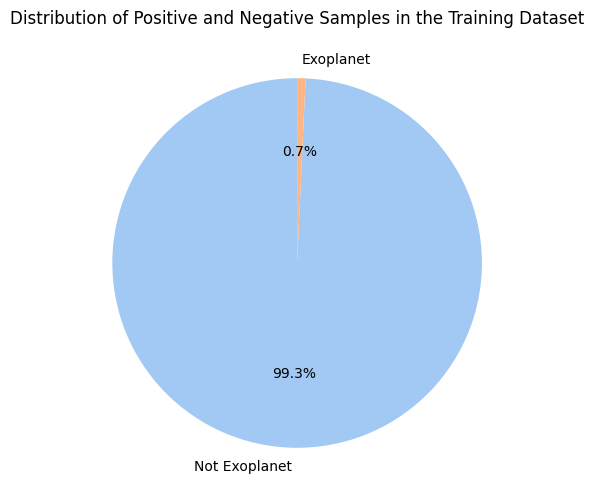

In [ ]:
label_counts = np.bincount(train_dataset.labels)
label_names = ['Not Exoplanet','Exoplanet']

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_names, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Positive and Negative Samples in the Training Dataset')
plt.show()

To deal with the imbalance of our dataset, let's Synthetic Minority
Over-Sampling Technique (SMOTE). SMOTE works by
generating synthetic samples from the minority class to balance the
distribution (typically implemented using the nearest neighbors
strategy). By implementing SMOTE, we attempt to reduce bias towards
stars without exoplanets (the majority class).

In [ ]:
# Step 2: Apply SMOTE to deal with the unbalanced data
smote = SMOTE(sampling_strategy='all') # initialize a smote, while sampling_strategy='all' means setting all the classes to the same size
train_dataset.features, train_dataset.labels = smote.fit_resample(train_dataset.features, train_dataset.labels) # update the labels and features to the resampled data

print("Class distribution in the training dataset after SMOTE:", pd.Series(train_dataset.labels).value_counts())
print("Class distribution in the testing dataset after SMOTE:", pd.Series(test_dataset.labels).value_counts())

Class distribution in the training dataset after SMOTE: 1    5050
0    5050
dtype: int64
Class distribution in the testing dataset after SMOTE: 0    565
1      5
dtype: int64


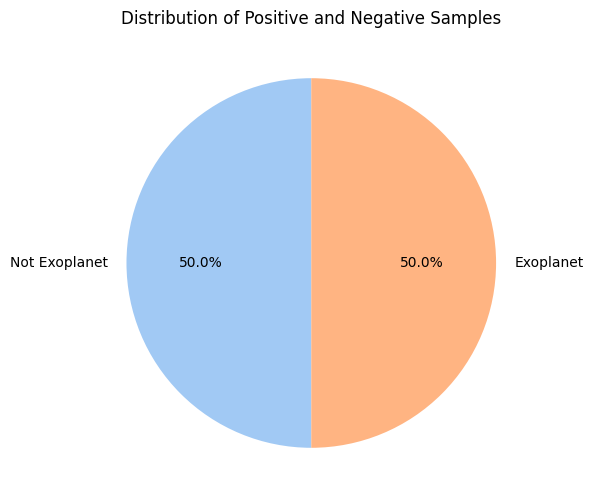

In [ ]:
label_counts = np.bincount(train_dataset.labels)
label_names = ['Not Exoplanet','Exoplanet']

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_names, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Positive and Negative Samples')
plt.show()

## 1.4 Create the DataLoader

We will create a dataloader to help batch and shuffle the data during training and testing. In the initialization of the dataloader, the parameters include: the dataset to be loaded, the batch size, a shuffle argument to determine whether or not to shuffle the dataset after each epoch, and a `drop_last` parameter that decides whether or not a potential final "incomplete" batch is dropped.

In [ ]:
# Step 3: Create dataloader
batch_size = 64 # determines the number of samples in each batch during training
spike_grad = surrogate.fast_sigmoid(slope=25) #
beta = 0.5 # initialize a beta value of 0.5
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # create a dataloader for the trainset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # create a dataloader for the testset

## 1.5 Description of the data

After loading the data, let's see what our data looks like.


In [ ]:
print(train_dataset.data.head(1))

   LABEL  FLUX.1  FLUX.2  FLUX.3  FLUX.4  FLUX.5  FLUX.6  FLUX.7  FLUX.8  \
0      2   93.85   83.81    20.1  -26.98  -39.56 -124.71 -135.18  -96.27   

   FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  FLUX.3192  \
0  -79.89  ...     -78.07    -102.15    -102.15      25.13      48.57   

   FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      92.54      39.32      61.42       5.08     -39.54  

[1 rows x 3198 columns]


In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=("Star #0 (Exoplanet)", "Star #1 (Exoplanet)",
                                                   "Star #3000 (No-Exoplanet)", "Star #3001 (No-Exoplanet)"))
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(0)['feature']),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(1)['feature']),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(3000)['feature']),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(3001)['feature']),
    row=2, col=2
)
for i in range(1, 5):
    fig.update_xaxes(title_text="Time", row=(i-1)//2 + 1, col=(i-1)%2 + 1)
    fig.update_yaxes(title_text="Flux", row=(i-1)//2 + 1, col=(i-1)%2 + 1)

fig.update_layout(height=600, width=800, title_text="Exoplanets Flux vs No-Exoplanet Flux",showlegend=False)
fig.show()

# 2. Train and Test
## 2.1 Define Network with snnTorch

The code block below follows the same syntax as with the [official snnTorch tutorials](https://snntorch.readthedocs.io/en/latest/tutorials/index.html).
In contrast to other tutorials however, this model passes data across the entire sequence in parallel.
In that sense, it is more akin to how attention-based mechanisms take data.
Turning this into a more 'online' method would likely involve pre-processing to downsample the exceedingly long sequence length.

In [ ]:
# Step 4: Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers (3 linear layers and 3 leaky layers)
        self.fc1 = nn.Linear(3197, 128) # takes an input of 3197 and outputs 128
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(64, 64) # takes an input of 64 and outputs 68
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc3 = nn.Linear(32, 2) # takes in 32 inputs and outputs our two outputs (planet with/without an exoplanet)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.softmax = nn.Softmax(dim=1) # softmax applied with a dimension of 1

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        cur1 = F.max_pool1d(self.fc1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool1d(self.fc2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc3(spk2.view(batch_size, -1))

        # return cur3
        return cur3

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = Net() # initialize the model to the new class.

## 2.2 Define the Loss function and the Optimizer


In [ ]:
# Step 5: Define the Loss function and the Optimizer
criterion = nn.CrossEntropyLoss()  # look up binarycross entropy if we have time
optimizer = optim.SGD(model.parameters(), lr=0.001) # stochastic gradient descent with a learning rate of 0.001

## 2.3 Train and Test the Model over each EPOCH
### Sensitivity
 Sensitivity (Recall / True Positive Rate) measures the proportion of actual positive cases correctly identified by the model. It indicates the model's ability to correctly detect or capture all positive instances out of the total actual positives.

$$Sensitivity =  \frac{TP}{TP+FN} \tag{1}$$

TP stands for the True Positive prediction, which means the number of the positive samples that are correctly predicted. FN stands for the False Negative prediction, which means the number of the negative samples that are mistakenly predicted as positive samples.

### Specificity
On the other hand, specificity measures the proportion of actual negative cases correctly identified by the model. It indicates the model's ability to correctly exclude negative instances out of the total actual negatives.

$$Specificity =  \frac{TN}{TN+FP} \tag{2}$$

Similarly, TN stands for the True Negative prediction, FP stands for the False Positive prediction.

### AUC-ROC
The AUC-ROC (Area Under the Receiver Operating Characteristic curve) metric is commonly used for evaluating the performance of binary classification models, plotting the true positive rate against the false positive rate. It quantifies the model's ability to distinguish between classes, specifically its capacity to correctly rank or order predicted probabilities.

roc_auc_score(): returns a value between 0 or 1
 - Values > 0.5 and closer to 1 indicate that the model does well in distinguishing between the two classes
 - Values close to 0.5 represent that the model does no better than random guessing
 - Values < 0.5 demonstrate that the model performs worse than random guessing

Since there are minimal test values for stars with exoplanets, these
metrics are far better than accuracy alone for determining model performance. Let's list
all the varaiables that we need:

In [ ]:
# create a pandas dataframe to hold the current epoch, the accuracy， sensitivity, specificity, auc-roc and loss
results = pd.DataFrame(columns=['Epoch', 'Accuracy', 'Sensitivity', 'Specificity', 'AUC-ROC', 'Test Loss'])

And then define how many epochs we want the model to be trained:

In [ ]:
num_epochs = 100 # initialize a certain number of epoch iterations

Note that the best range for epochs is around 50 to 500 for our dataset.

Now let's train the model.

In [ ]:
for epoch in range(num_epochs): # iterate through num_epochs
    model.train() # forward pass
    for data in train_dataloader: # iterate through every data sample
        inputs, labels = data['feature'].float(), data['label']  # Float
        optimizer.zero_grad() # clear previously stored gradients
        outputs = model(inputs) #
        loss = criterion(outputs, labels) # calculates the difference (loss) between actual values and predictions
        loss.backward() # backward pass on the loss
        optimizer.step() # updates parameters

    # Test Set, evaluate the model every epoch
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        all_probs = []
        for data in test_dataloader:
            inputs, labels = data['feature'].float(), data['label']
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())


            softmax = torch.nn.Softmax(dim=1)
            probabilities = softmax(outputs)[:, 1]  # Assuming 1 represents the positive class
            all_probs.extend(probabilities.cpu().numpy())
        # output the accuracy (even though it is not very useful in this case)
        accuracy = 100 * correct / total
        # calculate teat loss
        # test_loss =
        # initialize a confusing matrix
        cm = confusion_matrix(all_labels, all_predicted)
        # grab the amount of true negatives and positives, and false negatives and positives.
        tn, fp, fn, tp = cm.ravel()
        # calculate sensitivity
        sensitivity = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0.0
        # calculate specificity
        specificity = 100 * tn / (tn + fp) if (tn + fp) > 0 else 0.0
        # calculate AUC-ROC
        auc_roc = 100 * roc_auc_score(all_labels, all_probs)
        print(
            f'Epoch [{epoch + 1}/{num_epochs}] Test Loss: {test_loss / len(test_dataloader):.2f} '
            f'Test Accuracy: {accuracy:.2f}% Sensitivity: {sensitivity:.2f}% Specificity: {specificity:.2f}% AUC-ROC: {auc_roc:.4f}%'
        )

        results = results._append({
            'Epoch': epoch + 1,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Test Loss': test_loss / len(test_dataloader),
            'AUC-ROC': auc_roc
        }, ignore_index=True)

Epoch [1/1000] Test Loss: 0.76 Test Accuracy: 3.32% Sensitivity: 100.00% Specificity: 2.37% AUC-ROC: 72.8402%
Epoch [2/1000] Test Loss: 0.75 Test Accuracy: 3.71% Sensitivity: 100.00% Specificity: 2.76% AUC-ROC: 73.0178%
Epoch [3/1000] Test Loss: 0.75 Test Accuracy: 3.71% Sensitivity: 100.00% Specificity: 2.76% AUC-ROC: 73.1558%
Epoch [4/1000] Test Loss: 0.75 Test Accuracy: 3.71% Sensitivity: 100.00% Specificity: 2.76% AUC-ROC: 73.2742%
Epoch [5/1000] Test Loss: 0.75 Test Accuracy: 3.71% Sensitivity: 100.00% Specificity: 2.76% AUC-ROC: 73.4911%
Epoch [6/1000] Test Loss: 0.75 Test Accuracy: 3.52% Sensitivity: 100.00% Specificity: 2.56% AUC-ROC: 73.3925%
Epoch [7/1000] Test Loss: 0.74 Test Accuracy: 3.71% Sensitivity: 100.00% Specificity: 2.76% AUC-ROC: 73.7278%
Epoch [8/1000] Test Loss: 0.74 Test Accuracy: 6.64% Sensitivity: 100.00% Specificity: 5.72% AUC-ROC: 74.1420%
Epoch [9/1000] Test Loss: 0.74 Test Accuracy: 7.42% Sensitivity: 100.00% Specificity: 6.51% AUC-ROC: 74.0434%
Epoch [10/

# 3. Visualize the Results


In [ ]:
#@title ## 3.1 Plot the Accuracy
# Step 7: plot the test metrics over each epoch
plt.figure(figsize=(10, 5))
sns.regplot(x='Epoch', y='Accuracy', data=results, marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#@title ## 3.2 Plot the Sensitivity
plt.figure(figsize=(10, 5))
sns.regplot(x='Epoch', y='Sensitivity', data=results, marker='o', label='Sensitivity')
plt.title('Sensitivity Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Sensitivity')
plt.show()

In [ ]:
#@title ## 3.3 Plot Specificity
plt.figure(figsize=(10, 5))
sns.regplot(x='Epoch', y='Specificity', data=results, marker='o')
plt.title('Specificity Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Specificity')
plt.show()

In [ ]:
#@title ## 3.4 Plot the Test Loss
plt.figure(figsize=(10, 5))
sns.regplot(x='Epoch', y='Test Loss', data=results, marker='o')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.show()

In [ ]:
#@title ## 3.5 Plot the AUC-ROC
plt.figure(figsize=(10, 5))
sns.regplot(x='Epoch', y='AUC-ROC', data=results, marker='o')
plt.title('AUC-ROC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC')
plt.show()

In [ ]:
#@title ## 3.5 Print all together
fig = make_subplots(rows=2, cols=3, subplot_titles=("Sensitivity", "Accuracy", "AUC-ROC", "Specificity", "Test Loss"))

# Sensitivity plot
fig.add_trace(
    go.Scatter(x=results['Epoch'], y=results['Sensitivity'], mode='markers', marker=dict(symbol='circle', size=8)),
    row=1, col=1
)
# fig.update_xaxes(title_text="Epoch", row=1, col=1)
# fig.update_yaxes(title_text="Sensitivity", row=1, col=1)

# Accuracy plot
fig.add_trace(
    go.Scatter(x=results['Epoch'], y=results['Accuracy'], mode='markers', marker=dict(symbol='circle', size=8)),
    row=1, col=2
)
# fig.update_xaxes(title_text="Epoch", row=1, col=2)
# fig.update_yaxes(title_text="Accuracy", row=1, col=2)

# AUC ROC plot
fig.add_trace(
    go.Scatter(x=results['Epoch'], y=results['AUC-ROC'], mode='markers', marker=dict(symbol='circle', size=8)),
    row=1, col=3
)
# fig.update_xaxes(title_text="Epoch", row=1, col=3)
# fig.update_yaxes(title_text="AUC ROC", row=1, col=3)

# Specificity plot
fig.add_trace(
    go.Scatter(x=results['Epoch'], y=results['Specificity'], mode='markers', marker=dict(symbol='circle', size=8)),
    row=2, col=1
)
# fig.update_xaxes(title_text="Epoch", row=2, col=1)
# fig.update_yaxes(title_text="Specificity", row=2, col=1)

# Test Loss plot
fig.add_trace(
    go.Scatter(x=results['Epoch'], y=results['Test Loss'], mode='markers', marker=dict(symbol='circle', size=8)),
    row=2, col=2
)

# Define different y-axis labels
y_labels = ['True Positive Rate (TPR)', 'Accuracy', 'AUC-ROC', 'True False Rate (TFR)', 'Test Loss']

for i in range(1, 6):
    row_num = (i - 1) // 3 + 1
    col_num = (i - 1) % 3 + 1

    fig.update_xaxes(title_text="Epochs", row=row_num, col=col_num)
    fig.update_yaxes(title_text=y_labels[i-1], row=row_num, col=col_num)

# Update layout
fig.update_layout(
    height=600,
    width=1000,
    title_text="Metrics Over Epochs",
    showlegend=False,
    margin=dict(l=50, r=50, t=80, b=50)
)

# Show the plot
fig.show()

# Conlusion

In [ ]:
# Save the model if needed
# torch.save(model.state_dict(), 'custom_model.pth')


You should now have a grasp of how spiking neural network can contribute
to deep space mission along with some limitations.

A special thanks to Giridhar Vadhul and Sahil Konjarla for their super helpful
advice on defining and training the network.



If you like this project, please consider starring ⭐ the snnTorch repo on GitHub
as it is the easiest and best way to support it.

# Acknowledgments
This project was supported in-part by the National Science Foundation RCN-SC 2332166.